# Wasserstein Distances

The Wasserstein distance, also known as the Earth Mover's Distance (EMD), is a measure of dissimilarity between two probability distributions. It quantifies the minimum amount of work needed to transform one distribution into another. When applied to images, the Wasserstein distance can be used to compare two 2D images by treating them as probability distributions, and when two images have a large EMD between them, it signifies a significant dissimilarity in their visual content. In this notebook, our goal is to calculate the EMD of an image, along with their augmentations, to find which augmentations have invariance. Invariance in image augmentation refers to the property where the augmented image remains unchanged or shows consistent behavior despite certain transformations applied to it.

## Import Libraries

In [14]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.stats as stats
import scipy.integrate as integrate

sys.path.append(os.path.abspath('./../../sdo_augmentation/'))
from augmentation import Augmentations
from image_utils import stitch_adj_imgs

# Calculating the 1D Power Spectrum and Wasserstein Distances

In [15]:
# Calculates 1d Power Spectrum
def power_spectrum_1d(image):

    # Get pixel count
    pixel_count = image.shape[0]

    # Convert into fourier transform
    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)

    #Calculate 1D power spectrum
    k_frequencies = np.fft.fftfreq(pixel_count) * pixel_count
    k_frequencies2D = np.meshgrid(k_frequencies, k_frequencies)
    k_norm = np.sqrt(k_frequencies2D[0] ** 2 + k_frequencies2D[1] ** 2)
    k_bins = np.arange(0.5, pixel_count // 2 + 1, 1.)
    k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
    a_bins, _, _ = stats.binned_statistic(k_norm.flatten(),
                                        (fourier_amplitudes ** 2).flatten(),
                                        statistic = "mean", bins = k_bins)
    a_bins *= np.pi * (k_bins[1:] ** 2 - k_bins[:-1] ** 2)
    
    return a_bins

In [16]:
def perform_experiment(image, augmentations, augmentation_degrees, original_power_spectrum_1d, is_super = False, fill_void = False):

    # Values to return
    power_spectrums = []
    wasserstein_distances = []

    for i in augmentation_degrees:

        # Perform augmentations
        augmentation = Augmentations(image, {augmentations: i})

        if fill_void == True:
            augmented_image, _ = augmentation.perform_augmentations(fill_void = 'Nearest')
        else:
            augmented_image, _ = augmentation.perform_augmentations()

        if is_super == True:
            pixel_count = image.shape[0] // 3
            augmented_image = augmented_image[pixel_count:pixel_count * 2, pixel_count:pixel_count * 2]
        
        # Get 1D power spectrum
        power_spectrums.append(power_spectrum_1d(augmented_image))

        # Calculate Wasserstein Distance of original image vs augmented iamge
        wasserstein_distance = stats.wasserstein_distance(np.arange(len(original_power_spectrum_1d)),
                                                        np.arange(len(power_spectrums[-1])),
                                                        original_power_spectrum_1d, 
                                                        power_spectrums[-1])
        
        wasserstein_distances.append(wasserstein_distance)

    return power_spectrums, wasserstein_distances
        

Get 1D Power Spectrum and Wasserstein Distance of Original Image

In [17]:
# Open image
image_dir = './../../AIA171_Miniset_BW/20130217_000001_aia_171_4k/tiles/'
image_name = '20130217_000001_aia_171_4k_tile_1024_3072.jpg'
image = np.array(Image.open(image_dir + image_name).convert('L')).astype(float) / 255
super_image = stitch_adj_imgs(image_dir, image_name, os.listdir(image_dir), True)
super_image = np.dot(super_image[..., :3], [0.2989, 0.5870, 0.1140])
original_power_spectrum_1d = power_spectrum_1d(image)
pixel_count = image.shape[0]

# Investigating with Augmentations

### Rotation

In [18]:
# Create set of degrees to rotate
set_degrees = np.arange(5, 50, 5)

rotated_spectrum_none, rotated_distance_none = perform_experiment(image, 'rotate', set_degrees, original_power_spectrum_1d, False, False)
rotated_spectrum_fill, rotated_distance_fill = perform_experiment(image, 'rotate', set_degrees, original_power_spectrum_1d, False, True)
rotated_spectrum_super, rotated_distance_super = perform_experiment(super_image, 'rotate', set_degrees, original_power_spectrum_1d, True, False)

[Text(1, 0, 'Nearest Neighbors'), Text(2, 0, 'Super Image')]

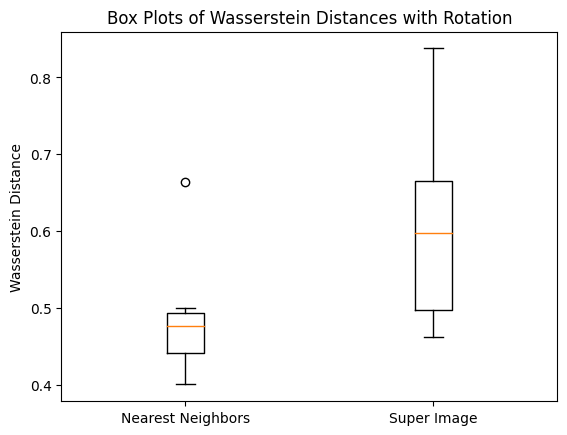

In [19]:
# Creates box plot of Wasserstein Distances with different fill methods
boxplots = {'Nearest Neighbors': rotated_distance_fill, 'Super Image': rotated_distance_super}
fig, ax = plt.subplots()
ax.set_title('Box Plots of Wasserstein Distances with Rotation')
ax.set_ylabel('Wasserstein Distance')
ax.boxplot(boxplots.values())
ax.set_xticklabels(boxplots.keys())

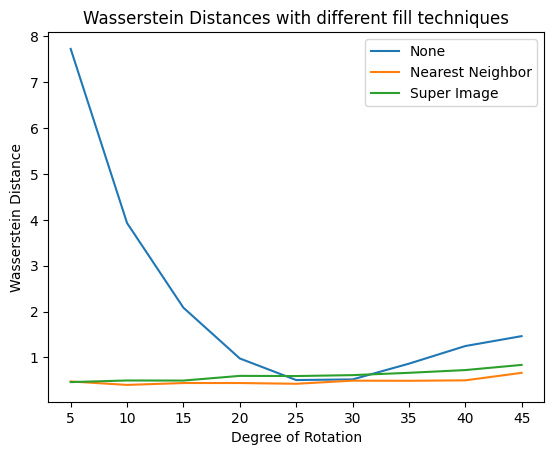

In [20]:
# Creates a plot of Wasserstein Distances with different fill methods
plt.title('Wasserstein Distances with different fill techniques')
plt.plot(set_degrees, rotated_distance_none)
plt.plot(set_degrees, rotated_distance_fill)
plt.plot(set_degrees, rotated_distance_super)
plt.legend(['None', 'Nearest Neighbor', 'Super Image'])
plt.xlabel('Degree of Rotation')
plt.ylabel('Wasserstein Distance')
plt.show()

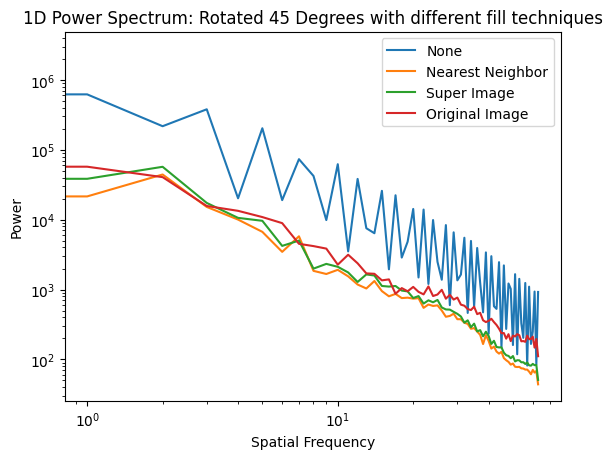

In [21]:
# Compares last rotation with and without fill_void
plt.title('1D Power Spectrum: Rotated ' + str(set_degrees[-1]) + ' Degrees with different fill techniques')
plt.loglog(rotated_spectrum_none[-1])
plt.loglog(rotated_spectrum_fill[-1])
plt.loglog(rotated_spectrum_super[-1])
plt.loglog(original_power_spectrum_1d)
plt.legend(['None', 'Nearest Neighbor', 'Super Image', 'Original Image'])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()

### Brightness

In [22]:
# Create set of values to brighten
set_brightness = np.round(np.arange(.5, 1.6, .1), 2)
brightness_spectrum, brightness_distance = perform_experiment(image, 'brighten', set_brightness, original_power_spectrum_1d, False, False)

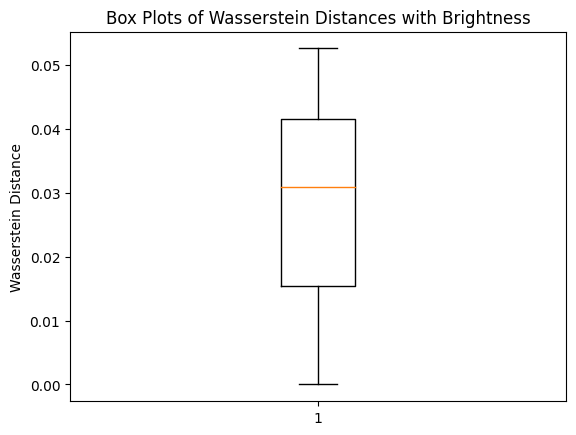

In [23]:
plt.boxplot(brightness_distance)
plt.title('Box Plots of Wasserstein Distances with Brightness')
plt.ylabel('Wasserstein Distance')
plt.show()

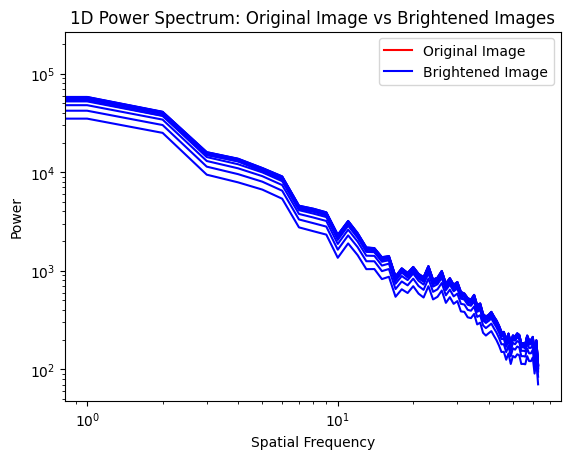

In [37]:
plt.title('1D Power Spectrum: Original Image vs Brightened Images')
plt.loglog(original_power_spectrum_1d, color = 'red')
for i in brightness_spectrum:
    plt.loglog(i, color = 'blue')
plt.legend(['Original Image', 'Brightened Image'])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()

### Translation

In [38]:
# Create set of degrees to translate
set_translation = np.arange(-10, 11, 2)
translated_spectrum_none, translated_distance_none = perform_experiment(image, 'translate', set_translation, original_power_spectrum_1d, False, False)
translated_spectrum_fill, translated_distance_fill = perform_experiment(image, 'translate', set_translation, original_power_spectrum_1d, False, True)
translated_spectrum_super, translated_distance_super = perform_experiment(super_image, 'translate', set_translation, original_power_spectrum_1d, True, False)

IndexError: invalid index to scalar variable.

In [26]:
# Creates box plot of Wasserstein Distances with different fill methods
boxplots = {'None': translated_distance_none, 'Nearest Neighbors': translated_distance_fill, 'Super Image': translated_distance_super}
fig, ax = plt.subplots()
ax.set_title('Box Plots of Wasserstein Distances with Translation')
ax.set_ylabel('Wasserstein Distance')
ax.boxplot(boxplots.values())
ax.set_xticklabels(boxplots.keys())

NameError: name 'translated_distance_none' is not defined

In [27]:
# Creates box plot of Wasserstein Distances with different fill methods
boxplots = {'Nearest Neighbors': translated_distance_fill, 'Super Image': translated_distance_super}
fig, ax = plt.subplots()
ax.set_title('Box Plots of Wasserstein Distances with Translation')
ax.set_ylabel('Wasserstein Distance')
ax.boxplot(boxplots.values())
ax.set_xticklabels(boxplots.keys())

NameError: name 'translated_distance_fill' is not defined

NameError: name 'translated_spectrum_none' is not defined

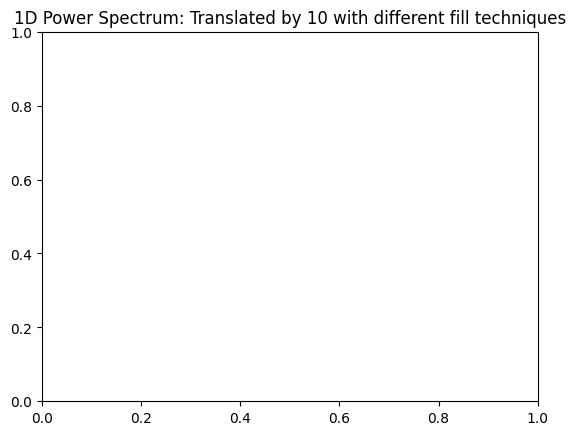

In [28]:
# Compares last rotation with and without fill_void
plt.title('1D Power Spectrum: Translated by ' + str(set_translation[-1]) + ' with different fill techniques')
plt.loglog(translated_spectrum_none[-1])
plt.loglog(translated_spectrum_fill[-1])
plt.loglog(translated_spectrum_super[-1])
plt.loglog(original_power_spectrum_1d)
plt.legend(['None', 'Nearest Neighbor', 'Super Image', 'Original Image'])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()

### Zoom

In [29]:
# Create set of degrees to zoom
set_zoom = np.round(np.arange(.8, 1.21, .04), 3)
zoomed_spectrum, zoomed_distance = perform_experiment(image, 'zoom', set_zoom, original_power_spectrum_1d, False, False)

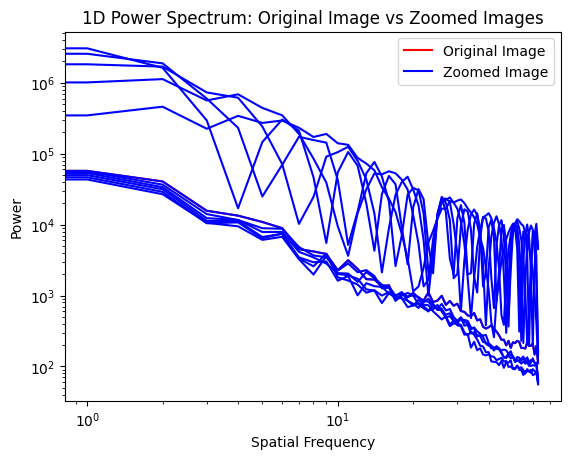

In [30]:
plt.title('1D Power Spectrum: Original Image vs Zoomed Images')
plt.loglog(original_power_spectrum_1d, color = 'red')
for i in zoomed_spectrum:
    plt.loglog(i, color = 'blue')
plt.legend(['Original Image', 'Zoomed Image'])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()

### V-Flip and H-Flip

In [31]:
# Calculate for v-flip
augmentation = Augmentations(image, {'v_flip': True})
v_flip_image, _ = augmentation.perform_augmentations()
v_flip_power_spectrum = power_spectrum_1d(v_flip_image)
wasserstein_distance = stats.wasserstein_distance(original_power_spectrum_1d, v_flip_power_spectrum)
print('V-Flip Wasserstein Distance:', wasserstein_distance)

# Calculate for h-flip
augmentation = Augmentations(image, {'h_flip': True})
h_flip_image, _ = augmentation.perform_augmentations()
h_flip_power_spectrum = power_spectrum_1d(h_flip_image)
wasserstein_distance = stats.wasserstein_distance(original_power_spectrum_1d, h_flip_power_spectrum)
print('H-Flip Wasserstein Distance:', wasserstein_distance)

V-Flip Wasserstein Distance: 9.64117674584486e-13
H-Flip Wasserstein Distance: 8.024692021990631e-13


### Blur

In [35]:
# Create set of degrees to zoom
set_blur = np.arange(1, 2, .1)
blurred_spectrum, blurred_distance = perform_experiment(image, 'blur', set_blur, original_power_spectrum_1d, False, False)

IndexError: invalid index to scalar variable.

NameError: name 'blurred_spectrum' is not defined

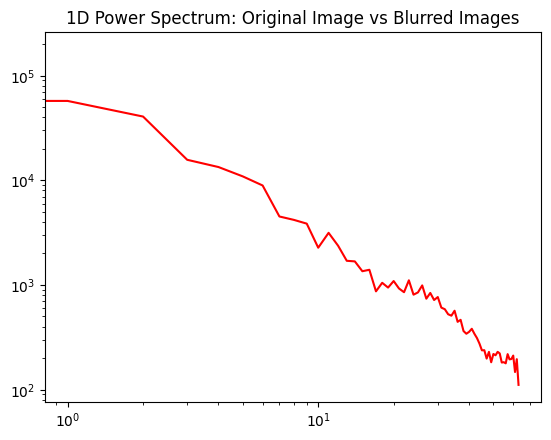

In [33]:
plt.title('1D Power Spectrum: Original Image vs Blurred Images')
plt.loglog(original_power_spectrum_1d, color = 'red')
for i in blurred_spectrum:
    plt.loglog(i, color = 'blue')
plt.legend(['Original Image', 'Blurred Image'])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()